In [9]:
%load_ext autoreload
%autoreload 2

from calc_del_lambda import import_lab_frame_spectra
lab = import_lab_frame_spectra('/home/agoga/Documents/nreshk/data/LabSpectra/', resolution=0)#,res*10)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


shk 0.2784475390477682
shk 0.28288634151937725
shk 0.29608312079291876
shk 0.3068303070153194
shk 0.307749126242894
shk 0.2555241395932904
>f8
shk 0.41501782204914983
>f8
shk 0.7349533938689256
shk 0.23008613211708365
shk 0.23818708893363938
shk 0.26319366607228567
shk 0.23332212279779818
shk 0.21660024322267765
shk 0.2550105832822149
shk 0.27362582888182796
[[5.80830971e+04 5.80561150e+04 5.80561113e+04 5.80501276e+04
  5.80451409e+04 5.80192120e+04 5.81740504e+04 5.81740466e+04
  5.81401117e+04 5.81401080e+04 5.80900612e+04 5.80900574e+04
  5.80890255e+04 5.80830933e+04 5.80501314e+04]
 [2.78447539e-01 2.82886342e-01 2.96083121e-01 3.06830307e-01
  3.07749126e-01 2.55524140e-01 4.15017822e-01 7.34953394e-01
  2.30086132e-01 2.38187089e-01 2.63193666e-01 2.33322123e-01
  2.16600243e-01 2.55010583e-01 2.73625829e-01]]
['lsc' 'lsc' 'lsc' 'lsc' 'lsc' 'lsc' 'lsc' 'lsc' 'lsc' 'lsc' 'lsc' 'lsc'
 'lsc' 'lsc' 'lsc']


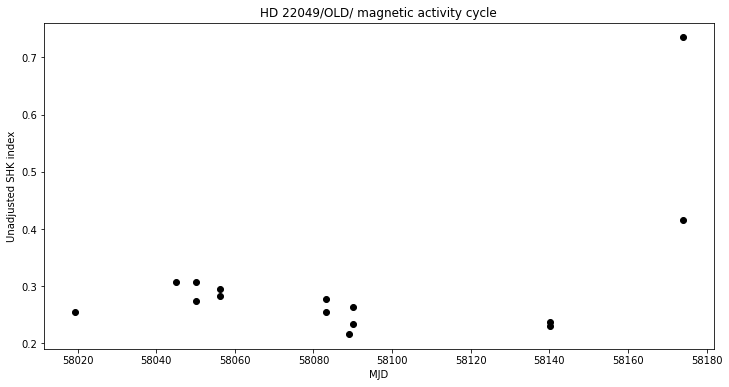

In [15]:
import scipy.constants as sc

import astropy.io.fits
import numpy as np
import os

from calc_shk import calc_targOlapf
from calc_shk import calc_shk


from calc_del_lambda import tmp_find_del_lam
from calc_del_lambda import lamda_zoom

from mk_flatolap import mk_flatolap
from matplotlib import pyplot as plt

from astropy.time import Time


def print_header(header):
    for h in header.keys():
        print(h, header[h])
def mjd_from_hdu(hdu):
    return hdu[0].header['MJD-OBS']

#https://stackoverflow.com/questions/47725773/finding-an-integer-key-of-a-python-dict-that-is-closest-to-a-given-integer
def find_nearest_mjd(dd,mjd):
    low = max([d for d in dd if d<= mjd])
    high = min([d for d in dd if d>= mjd])
    nearkey = low if mjd - low <= high - mjd else high
    return nearkey
def closestKey(dic, key):
    diff = {k:abs(k - key) for k in dic}
    return min(diff, key=diff.get)


dataPath ='/home/agoga/Documents/nreshk/data/'
setName = '22049/OLD/'



#        print(int(flatDate))
#print('-------------------------')
#for k in obsDict:
#    print(closestKey(flatDict,int(k)))

res = .01
label =''

waveFile=[]
specFile=[]
flatFile=[]
exclude = ['unpacked_files']
for root, dirs, files in os.walk(dataPath + setName):
    dirs[:] = [d for d in dirs if d not in exclude]
    
    for file in files:
        if file.endswith("-noflat.fits"):
            specFile.append(astropy.io.fits.open(os.path.join(root, file)))
        elif file.endswith("-wave.fits"):
            waveFile.append(astropy.io.fits.open(os.path.join(root, file)))
        elif file.endswith(".fits") and file.startswith("flat_") :
            #print(os.path.join(root, file))
            flatFile.append(astropy.io.fits.open(os.path.join(root, file)))
            
#print(len(waveFile))
#print(len(specFile))
#print(len(flatFile))
data = [[],[]]#,[]]
sites = []

for i in range(len(flatFile)):
    wvHDu = waveFile[i]
    sHDu = specFile[i]
    fHDu = flatFile[i]
    
    #print('wave file')
    #print(waveFile)
    #ret = mk_flatolap(oHDu[7].data, fHDu[0].data)
    if len(wvHDu)>1 and type(wvHDu[1]) == astropy.io.fits.hdu.table.BinTableHDU:
        #print('wavehdu')   
        #print(wvHDu.info())
        #print(wvHDu[1].data.dtype)
        #print(type(wvHDu[1].data))
        #print('done')
        #print('stuff ' + str(i))
        #print((wvHDu[1].data)[0])
        try:
            waveGrid = wvHDu[1].data['WavelenStar'][0]
            #print('1e')
        except:
            #print('2e')
            waveGrid=wvHDu[1].data['Wavelength'][0]
    elif len(wvHDu)>1:
        waveGrid = (wvHDu[1].data)[0]
    else:
        print(wvHDu[0].data.dtype)
        waveGrid = (wvHDu[0].data)[0]
    
    flat = (fHDu[0].data)
    ret = mk_flatolap(waveGrid,flat)
    lamGrid = ret[0]
    
    label=str(mjd_from_hdu(sHDu)) 
    
    #print('label: ' + label)
    #plt.figure()
    #plt.title('mjd: ' + str(oK))

    spec = sHDu[0].data[0]
    
    
    
    
    
    ##BEGIN PIPELINE
    targOlapf = calc_targOlapf(lamGrid,waveGrid,spec, ret[1], label)

    out = tmp_find_del_lam(lab[0]/10,lab[1], lamGrid, targOlapf,res)
    dLam = out[0]
    
    #lamda_zoom(lamGrid, out[2],lamGrid-out[0], out[3],[393.369,396.85,400.525,403.076,404.582,406.36], setName,label,.3)

    lamRef = 396.85
    #delta lamda / ref lamda * speed of light
    rv = dLam/ lamRef * sc.c 
    #rv from meters to km/s as desired by hk_windows
    rv = rv/10000
    #print('rv: ' + str(rv))
    shkRet = calc_shk(lamGrid, out[1], 0, teff=6420)
    
    shk = shkRet[0]
    windows = shkRet[1]
    
    print('shk ' + str(shk))
    #print('MJD: ' + str(oK) + ' w/ shk: ' + str(shk))
    if(shk < 0):
        continue
    data[0].append(mjd_from_hdu(sHDu))
    data[1].append(shk)
    sites.append(sHDu[0].header['SITEID'])
    

    wvHDu.close()
    sHDu.close()
    fHDu.close()

    
    


    
shkArray = np.asarray(data)
siteArray = np.asarray(sites)
print(shkArray)
print(siteArray)
plt.figure(figsize=(12,6))    
#t= Time(shkArray[0], format='mjd')
#t.format = 'decimalyear'
   
plt.plot(shkArray[0],shkArray[1], 'ko')
plt.title('HD '+setName+' magnetic activity cycle')
plt.xlabel('MJD')
plt.ylabel('Unadjusted SHK index')
#plt.savefig('images/shk_time_series.pdf')
plt.show()
plt.close()